## Pandas怎样实现groupby分组统计

类似SQL：  
select city,max(temperature) from city_weather group by city;

groupby：先对数据分组，然后在每个分组上应用聚合函数、转换函数

本次演示：  
一、分组使用聚合函数做数据统计  
二、遍历groupby的结果理解执行流程  
三、实例分组探索天气数据  

In [1]:
import pandas as pd
import numpy as np
# 加上这一句，能在jupyter notebook展示matplot图表
%matplotlib inline

In [2]:
df = pd.DataFrame({'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
                   'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
                   'C': np.random.randn(8),
                   'D': np.random.randn(8)})
df

,A,B,C,D
0,foo,one,-0.465039,0.305448
1,bar,one,-0.586374,0.414154
2,foo,two,0.986466,0.625463
3,bar,three,1.260499,0.179222
4,foo,two,-0.181215,1.420829
5,bar,two,-1.099765,-0.693486
6,foo,one,0.977137,0.709845
7,foo,three,-0.005127,0.945832


### 一、分组使用聚合函数做数据统计

#### 1、单个列groupby，查询所有数据列的统计

In [3]:
df.groupby('A').sum()

,B,C,D
A,,,
bar,onethreetwo,-0.425640,-0.100110
foo,onetwotwoonethree,1.312221,4.007417


我们看到：
1. groupby中的'A'变成了数据的索引列
2. 因为要统计sum，但B列不是数字，所以被自动忽略掉

#### 2、多个列groupby，查询所有数据列的统计

In [4]:
df.groupby(['A','B']).mean()

C         D
A   B                        
bar one   -0.586374  0.414154
    three  1.260499  0.179222
    two   -1.099765 -0.693486
foo one    0.256049  0.507646
    three -0.005127  0.945832
    two    0.402625  1.023146

我们看到：('A','B')成对变成了二级索引

In [5]:
df.groupby(['A','B'], as_index=False).mean()

,A,B,C,D
0,bar,one,-0.586374,0.414154
1,bar,three,1.260499,0.179222
2,bar,two,-1.099765,-0.693486
3,foo,one,0.256049,0.507646
4,foo,three,-0.005127,0.945832
5,foo,two,0.402625,1.023146


#### 3、同时查看多种数据统计

In [6]:
df.groupby('A')[["C", "D"]].agg(["sum", "mean", "std"])

C                             D                    
          sum      mean       std       sum      mean       std
A                                                              
bar -0.425640 -0.141880  1.241327 -0.100110 -0.033370  0.583620
foo  1.312221  0.262444  0.676877  4.007417  0.801483  0.415288

我们看到：列变成了多级索引

#### 4、查看单列的结果数据统计

In [7]:
# 方法1：预过滤，性能更好
df.groupby('A')['C'].agg(["sum", "mean", "std"])

,sum,mean,std
A,,,
bar,-0.425640,-0.141880,1.241327
foo,1.312221,0.262444,0.676877


In [8]:
# 方法2
df.groupby('A')[["C", "D"]].agg(["sum", "mean", "std"])['C']

,sum,mean,std
A,,,
bar,-0.425640,-0.141880,1.241327
foo,1.312221,0.262444,0.676877


#### 5、不同列使用不同的聚合函数

In [9]:
df.groupby('A').agg({"C":"sum", "D":"mean"})

,C,D
A,,
bar,-0.425640,-0.033370
foo,1.312221,0.801483


### 二、遍历groupby的结果理解执行流程

for循环可以直接遍历每个group

##### 1、遍历单个列聚合的分组

In [10]:
g = df.groupby('A')
g

In [11]:
for name,group in g:
    print(name)
    print(group)
    print()

bar
     A      B         C         D
1  bar    one -0.586374  0.414154
3  bar  three  1.260499  0.179222
5  bar    two -1.099765 -0.693486

foo
     A      B         C         D
0  foo    one -0.465039  0.305448
2  foo    two  0.986466  0.625463
4  foo    two -0.181215  1.420829
6  foo    one  0.977137  0.709845
7  foo  three -0.005127  0.945832



***可以获取单个分组的数据***

In [12]:
g.get_group('bar')

,A,B,C,D
1,bar,one,-0.586374,0.414154
3,bar,three,1.260499,0.179222
5,bar,two,-1.099765,-0.693486


##### 2、遍历多个列聚合的分组

In [13]:
g = df.groupby(['A', 'B'])

In [14]:
for name,group in g:
    print(name)
    print(group)
    print()

('bar', 'one')
     A    B         C         D
1  bar  one -0.586374  0.414154

('bar', 'three')
     A      B         C         D
3  bar  three  1.260499  0.179222

('bar', 'two')
     A    B         C         D
5  bar  two -1.099765 -0.693486

('foo', 'one')
     A    B         C         D
0  foo  one -0.465039  0.305448
6  foo  one  0.977137  0.709845

('foo', 'three')
     A      B         C         D
7  foo  three -0.005127  0.945832

('foo', 'two')
     A    B         C         D
2  foo  two  0.986466  0.625463
4  foo  two -0.181215  1.420829



可以看到，name是一个2个元素的tuple，代表不同的列

In [15]:
g.get_group(('foo', 'one'))

,A,B,C,D
0,foo,one,-0.465039,0.305448
6,foo,one,0.977137,0.709845


***可以直接查询group后的某几列，生成Series或者子DataFrame***

In [16]:
g['C']

In [17]:
for name, group in g['C']:
    print(name)
    print(group)
    print(type(group))
    print()

('bar', 'one')
1   -0.586374
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('bar', 'three')
3    1.260499
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('bar', 'two')
5   -1.099765
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'one')
0   -0.465039
6    0.977137
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'three')
7   -0.005127
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'two')
2    0.986466
4   -0.181215
Name: C, dtype: float64
<class 'pandas.core.series.Series'>



其实所有的聚合统计，都是在dataframe和series上进行的；

### 三、实例分组探索天气数据

In [18]:
fpath = "./datas/beijing_tianqi/beijing_tianqi_2018.csv"
df = pd.read_csv(fpath)
# 替换掉温度的后缀℃
df.loc[:, "bWendu"] = df["bWendu"].str.replace("℃", "").astype('int32')
df.loc[:, "yWendu"] = df["yWendu"].str.replace("℃", "").astype('int32')
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel
0,2018-01-01,3,-6,晴~多云,东北风,1-2级,59,良,2
1,2018-01-02,2,-5,阴~多云,东北风,1-2级,49,优,1
2,2018-01-03,2,-5,多云,北风,1-2级,28,优,1
3,2018-01-04,0,-8,阴,东北风,1-2级,28,优,1
4,2018-01-05,3,-6,多云~晴,西北风,1-2级,50,优,1


In [19]:
# 新增一列为月份
df['month'] = df['ymd'].str[:7]
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel,month
0,2018-01-01,3,-6,晴~多云,东北风,1-2级,59,良,2,2018-01
1,2018-01-02,2,-5,阴~多云,东北风,1-2级,49,优,1,2018-01
2,2018-01-03,2,-5,多云,北风,1-2级,28,优,1,2018-01
3,2018-01-04,0,-8,阴,东北风,1-2级,28,优,1,2018-01
4,2018-01-05,3,-6,多云~晴,西北风,1-2级,50,优,1,2018-01


#### 1、查看每个月的最高温度

In [20]:
data = df.groupby('month')['bWendu'].max()
data

month
2018-01     7
2018-02    12
2018-03    27
2018-04    30
2018-05    35
2018-06    38
2018-07    37
2018-08    36
2018-09    31
2018-10    25
2018-11    18
2018-12    10
Name: bWendu, dtype: object

In [21]:
type(data)

pandas.core.series.Series

<Axes: xlabel='month'>

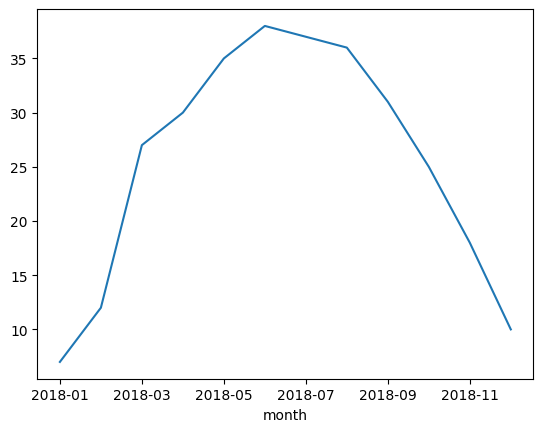

In [22]:
data.plot()

#### 2、查看每个月的最高温度、最低温度、平均空气质量指数

In [23]:
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel,month
0,2018-01-01,3,-6,晴~多云,东北风,1-2级,59,良,2,2018-01
1,2018-01-02,2,-5,阴~多云,东北风,1-2级,49,优,1,2018-01
2,2018-01-03,2,-5,多云,北风,1-2级,28,优,1,2018-01
3,2018-01-04,0,-8,阴,东北风,1-2级,28,优,1,2018-01
4,2018-01-05,3,-6,多云~晴,西北风,1-2级,50,优,1,2018-01


In [24]:
group_data = df.groupby('month').agg({"bWendu":"max", "yWendu":"min", "aqi":"mean"})
group_data

,bWendu,yWendu,aqi
month,,,
2018-01,7,-12,60.677419
2018-02,12,-10,78.857143
2018-03,27,-4,130.322581
2018-04,30,1,102.866667
2018-05,35,10,99.064516
2018-06,38,17,82.300000
2018-07,37,22,72.677419
2018-08,36,20,59.516129
2018-09,31,11,50.433333


<Axes: xlabel='month'>

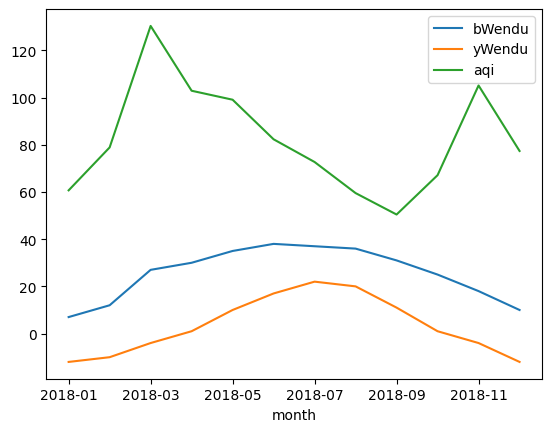

In [25]:
group_data.plot()